# CORG Quickstart Tutorial

CORG stands for "COrporal Geometrics". As suggested by its name, it's a module for performing inference in copora that have been embedded in some geometrical space.

Inputs are documents, binary categories for them, and positions for documents.

CORG does two things: 

1) I tests whether a given space direction servers as a good classifier for some binary category of documents. For this, it fits a logistic regression model on the dimension and repots accuracy metrics.

2) Given a binary classification of documents, it finds the space direction on which we can fit the best logistic regression binary classifier, i.e., the direction that best dichotomizes the documents labeled as belonging to one of two categories.


## Loading example data


In [1]:
import pandas as pd
docs_df = pd.read_csv('CORG_quicstart_data.csv')

Our example data contains documents/entries, with their document id, coordinates d1, d2, d3 in some geometrical space, and a label.

In [2]:
docs_df.columns

Index(['entity', 'd1', 'd2', 'd3', 'label'], dtype='object')

Label column provides a binary classification of documents. In this case, documents are short Twitter bio profile descriptions mentioning Trump or Biden.


In [3]:
docs_df['label'].value_counts()

Trump    50159
Biden    10229
Name: label, dtype: int64

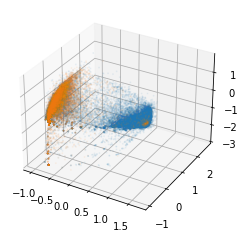

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for label in docs_df['label'].unique():
    df = docs_df[docs_df['label']==label]
    ax.scatter(df['d1'], df['d2'], df['d3'],alpha=0.05,s=1)

## 1) Testing whether a given dimension separates types of documents

We suspect some dimensions might be linked to the label of documents. For example, that a dimension captures a concept of importance to the label in a way that allows distinguishing documents.

If we inspect the density along the dimensions, this seems to be the case for d1.

<AxesSubplot:xlabel='d3', ylabel='Density'>

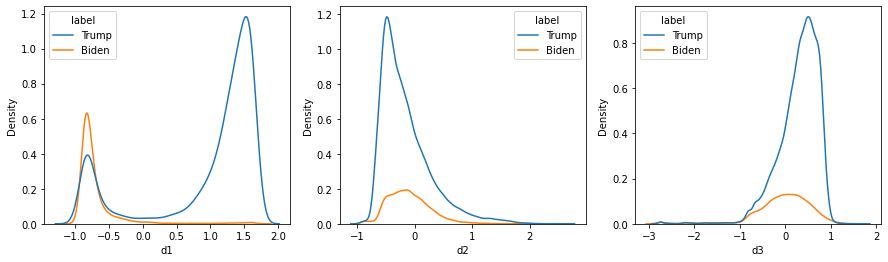

In [5]:
import seaborn as sn
fig = plt.figure(figsize=(15,4))# width, height inches
ax = {1:fig.add_subplot(1,3,1),2:fig.add_subplot(1,3,2),3:fig.add_subplot(1,3,3)}
sn.kdeplot(data=docs_df,x='d1',hue='label',ax=ax[1])
sn.kdeplot(data=docs_df,x='d2',hue='label',ax=ax[2])
sn.kdeplot(data=docs_df,x='d3',hue='label',ax=ax[3])

CORG provides a wrapper to compute the accuracy metrics for classification achieved with a Logistic Regression along any dimension.

In [6]:
from corg import BenchmarkDimension

We need to provide a label column with binary values.

In [7]:
docs_df['label'] = (docs_df['label']=='Biden').astype(int)


In [8]:
model_d1 = BenchmarkDimension()

We create one dataframe with the labels (Y) and other with the coordinates of documents (X).

In [9]:
Y_d1 = docs_df[['entity','label']]
X_d1 = docs_df[['entity','d1']]
model_d1.fit(X_d1, Y_d1)

BenchmarkDimension()

CORG computes the accuracy metric of the classification that would result from using the Logistic Regression fitted with the labels and the coordinates. Using d1 achieves a 0.62 F1-score in separating documents mentioning Trump and Biden.

In [10]:
print('d1: Precision=%.2f, Recall=%.2f, F1-score=%.2f, '%(model_d1.precision_train_,model_d1.recall_train_,model_d1.f1_score_train_))

d1: Precision=0.55, Recall=0.73, F1-score=0.62, 


As expected, this is higher that the accuracy achievable using the other dimensions; for example, d3.

In [11]:
model_d3 = BenchmarkDimension()

In [12]:
Y_d3 = docs_df[['entity','label']]
X_d3 = docs_df[['entity','d3']]
model_d3.fit(X_d3, Y_d3)

BenchmarkDimension()

In [13]:
print('d3: Precision=%.2f, Recall=%.2f, F1-score=%.2f, '%(model_d3.precision_train_,model_d3.recall_train_,model_d3.f1_score_train_))

d3: Precision=0.53, Recall=0.04, F1-score=0.07, 


## 2) Finding the spatial direction that best separates types of documents

But maybe we don't know what would be dimension that would best separate our two groups of documents. CORG provides a wrapper of this, based on multivariate Logistic Regression.

In [14]:
from corg import DiscoverDimension

In [15]:
model = DiscoverDimension()

This time, we need to provide all the dimensions of the space in which we would like to find a good direction.

In [16]:
Y = docs_df[['entity','label']]
X = docs_df[['entity','d1','d2','d3']]
model.fit(X, Y)

DiscoverDimension()

The model now contains a decision boudary (an hyperplane) for a binary classification. We can retrieve the coefficients and the unit normal. The coefficients are save in model_decision_boundary_, under the following convention:

decision boundary = [$a_n$,$a_{n-1}$,...,$a_1$,$a_0$]

for an hyperplane:

$\sum_{n=0}^{dims} a_n x^n$



In [17]:
print(model.model_decision_boundary_)

[-2.390534686730701, 0.32755987082093785, -0.008958569603504718, -1.6658971870199257]


In [18]:
print(model.decision_hyperplane_unit_normal)

[-0.9907355859857582, 0.13575424040678627, -0.0037127985446053897]


(Text(0.5, 0, 'd2'), Text(0, 0.5, 'd3'))

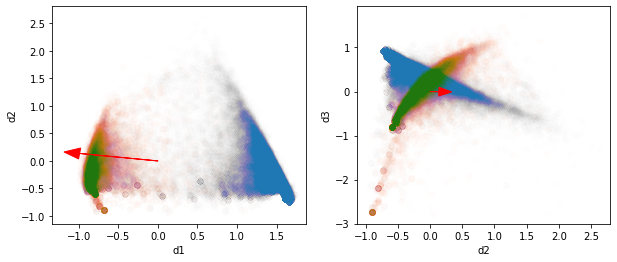

In [19]:
import matplotlib.pyplot as plt


normal = model.decision_hyperplane_unit_normal

fig = plt.figure(figsize=(10,4))# width, height inches
ax = {1:fig.add_subplot(1,2,1),2:fig.add_subplot(1,2,2)}
ax[1].scatter(docs_df.loc[docs_df['label'].astype(bool),'d1'],docs_df.loc[docs_df['label'].astype(bool),'d2'],alpha=0.01,c='tab:orange')
ax[1].scatter(docs_df.loc[~docs_df['label'].astype(bool),'d1'],docs_df.loc[~docs_df['label'].astype(bool),'d2'],alpha=0.002,c='tab:blue')
ax[1].arrow(0, 0, normal[0], normal[1],color='red',head_width=0.2,head_length=0.2)
ax[1].set_xlabel('d1'),ax[1].set_ylabel('d2'),
ax[2].scatter(docs_df.loc[docs_df['label'].astype(bool),'d2'],docs_df.loc[docs_df['label'].astype(bool),'d3'],alpha=0.01,c='tab:orange')
ax[2].scatter(docs_df.loc[~docs_df['label'].astype(bool),'d2'],docs_df.loc[~docs_df['label'].astype(bool),'d3'],alpha=0.002,c='tab:blue')
ax[2].arrow(0, 0, normal[1], normal[2],color='red',head_width=0.2,head_length=0.2)
ax[2].set_xlabel('d2'),ax[2].set_ylabel('d3'),

This new direction achieves a better accuracy if used in binary classification with a Logistic Regression model:

In [20]:
print('Precision=%.2f, Recall=%.2f, F1-score=%.2f, '%(model.precision_train_,model.recall_train_,model.f1_score_train_))

Precision=0.55, Recall=0.75, F1-score=0.63, 


But the accuracy gain is marginal becase the found direction and d1 are similar.